In [80]:
#Angular-spectral cube maker notebook:
from pysides.gen_fluxes import gen_Snu_arr
from astropy.io import fits
import astropy.units as u
import scipy.constants as cst
import numpy as np
from astropy import wcs
from astropy.stats import gaussian_fwhm_to_sigma
import astropy.convolution as conv
import datetime
from astropy.table import Table
import pickle
from copy import deepcopy
import os
from IPython import embed
from pysides.make_cube import *

#1st, load the catalog containing your light cone. I dont have a specific method for that, as matthieu built the lightcone himself from Uchuu. 
#But Ryan has a code to create the lightcone right ?
#The catalog thus contains the (ra dec redshift) of your galaxies. 
cat = Table.read('/home/mvancuyck/pySIDES_from_original.fits')
cat = cat.to_pandas()
#Select only a few sources, otherwise the notebook will crash when generating the continuum fluxes.
cat = cat.loc[(cat['redshift']>0.5)]
cat = cat.loc[(cat['redshift']<0.6)]

In [81]:
#1st: set WCS
res = 45 #arcsecs
dnu = 4 #GHz
pixel_sr = (res * np.pi/180/3600)**2 #solid angle of the pixel in sr
# frequency info in Hz and spatial resolution in arcsecs
params_cube = {'freq_min':715*1e9, 'freq_max':1250*1e9, 'freq_resol':dnu*1e9, "pixel_size":res} 
# Create the wcs to handle conversion from (ra,dec, observed freaquency) to (y,x,z) in the spatial-spectral cube
cube_prop_dict = set_wcs(cat, params_cube) 
#PS: be careful, Y axis goes first when building the cube...

In [82]:
#You want your spectral axis ? Then do:  
z = np.arange(0,cube_prop_dict['shape'][0],1) #This is correct because in SIDES we have a fixed absolute spectral resolution. 
#Ps: You might want another method than np.arange if your frequency bins are more complex. 
w = cube_prop_dict['w'] #The WCS object
freq_list = w.swapaxes(0, 2).sub(1).wcs_pix2world(z, 0)[0]
freq_list

array([7.150e+11, 7.190e+11, 7.230e+11, 7.270e+11, 7.310e+11, 7.350e+11,
       7.390e+11, 7.430e+11, 7.470e+11, 7.510e+11, 7.550e+11, 7.590e+11,
       7.630e+11, 7.670e+11, 7.710e+11, 7.750e+11, 7.790e+11, 7.830e+11,
       7.870e+11, 7.910e+11, 7.950e+11, 7.990e+11, 8.030e+11, 8.070e+11,
       8.110e+11, 8.150e+11, 8.190e+11, 8.230e+11, 8.270e+11, 8.310e+11,
       8.350e+11, 8.390e+11, 8.430e+11, 8.470e+11, 8.510e+11, 8.550e+11,
       8.590e+11, 8.630e+11, 8.670e+11, 8.710e+11, 8.750e+11, 8.790e+11,
       8.830e+11, 8.870e+11, 8.910e+11, 8.950e+11, 8.990e+11, 9.030e+11,
       9.070e+11, 9.110e+11, 9.150e+11, 9.190e+11, 9.230e+11, 9.270e+11,
       9.310e+11, 9.350e+11, 9.390e+11, 9.430e+11, 9.470e+11, 9.510e+11,
       9.550e+11, 9.590e+11, 9.630e+11, 9.670e+11, 9.710e+11, 9.750e+11,
       9.790e+11, 9.830e+11, 9.870e+11, 9.910e+11, 9.950e+11, 9.990e+11,
       1.003e+12, 1.007e+12, 1.011e+12, 1.015e+12, 1.019e+12, 1.023e+12,
       1.027e+12, 1.031e+12, 1.035e+12, 1.039e+12, 

In [83]:
#You want the position of the sources in the cube in term of pixel? they are pre-computed by the set_wcs method()
(cube_prop_dict['pos'][0], cube_prop_dict['pos'][1])

(array([40.30777061, 40.28185006, 62.8816725 , ..., 40.01959854,
        49.87480852, 47.18638579]),
 array([ 58.44685302,  58.39469488,  56.87325207, ..., 104.47214689,
        108.13966188, 110.79202073]))

In [84]:
#Now the z position depends of the rest frame frequency of the radiation, and the redshift of the emitter.  
#E.g, for CII, we first compute the intensity of the line for each object given the (flux integrated over the linewidth) and the channel in which it should fall:

print('Compute channel locations and flux densities of [CII] line (De Looze et al.  recipe)...')
Snu, channels = line_channel_flux_densities('CII_de_Looze', 1900.53690000, cat, cube_prop_dict)
    
#Then you can build the CII spatial-spectral cube: 
print('Generate the non-smoothed [CII] cube...')
CII_nobeam_Jypix, edges = np.histogramdd(sample=(channels, cube_prop_dict['pos'][0], cube_prop_dict['pos'][1]), 
                                         bins=(cube_prop_dict['z_edges'], cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), 
                                         weights=Snu)

#Then convert it from Jy/pix to MJy/sr
CII_MJysr = CII_nobeam_Jypix / pixel_sr / 1e6

#gen_Snu_arr method is to continuum emission what line_channel_flux_densities method is to lines: 
lambda_list =  ( cst.c * (u.m/u.s)  / (np.asarray(freq_list)*1e9 * u.Hz)  ).to(u.um)
SED_dict = pickle.load(open('pysides/SEDfiles/SED_finegrid_dict.p', "rb"))
Snu_arr = gen_Snu_arr(lambda_list.value, SED_dict, cat["redshift"], cat['mu']*cat["LIR"], cat["Umean"], cat["Dlum"], cat["issb"])
histo, edges = np.histogramdd(sample=(channels,cube_prop_dict['pos'][0], cube_prop_dict['pos'][1]), bins=(cube_prop_dict['z_edges'], cube_prop_dict['y_edges'], cube_prop_dict['x_edges']), weights=Snu_arr[:, 0])
continuum = histo.value / pixel_sr / 1e6

#Et voila, you have your CII and continuum cubes, ready to be added to each other to create an 'observed' TIM cube. 


Compute channel locations and flux densities of [CII] line (De Looze et al.  recipe)...
Generate the non-smoothed [CII] cube...


Text(0, 0.5, '$\\rm P$(k) [$\\rm Jy^2/sr^2.Mpc^3]$')

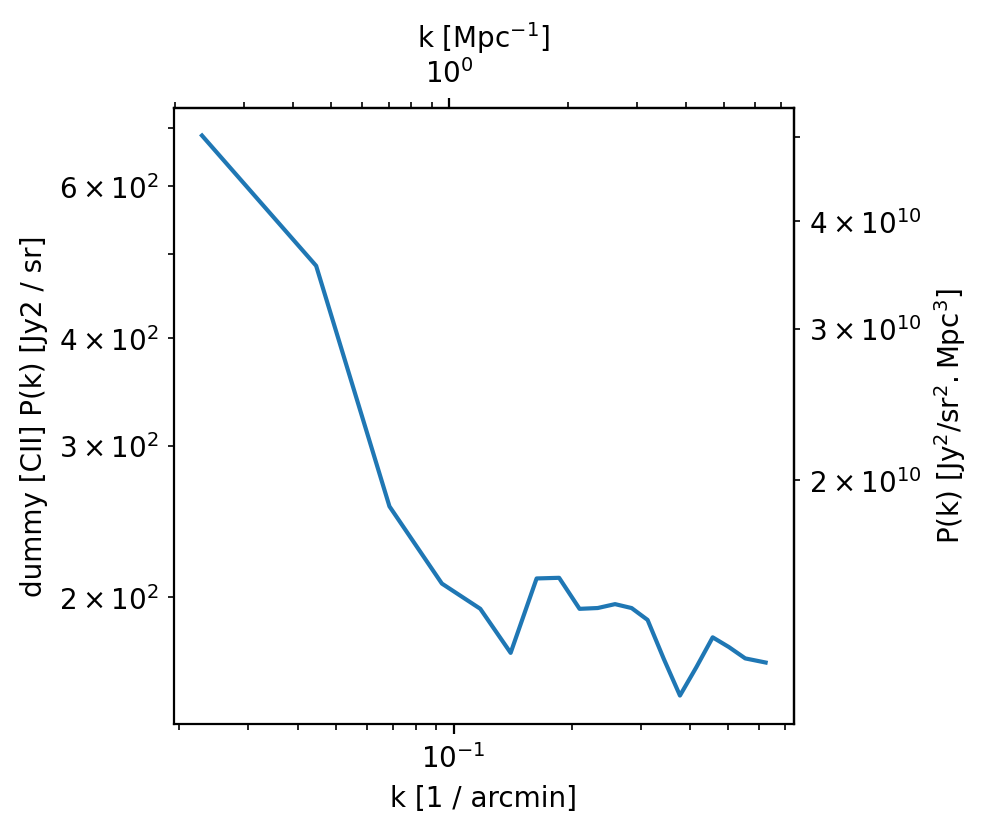

In [85]:
#Measuring the power spectrum in ONE spectral channel: 
from set_k import *

from functools import partial

i=128
k_nyquist, k_min, delta_k, k_bintab, k, k_map = set_k_infos(CII_map.shape[1],CII_map.shape[0], res*u.arcsec, delta_k_over_k = 0.1)
pk, k = my_p2(CII_MJysr[i,:,:]*u.MJy/u.sr, res*u.arcsec, k_bintab, u.Jy**2/u.sr, u.arcmin**-1 )

z = 1900.53690000/(freq_list[i]/1e9)-1
Dc, delta_Dc, pk_3d_to_2d, k_3d_to_2d, full_volume_covered = cosmo_distance( z, dnu*u.GHz, freq_list[i]/1e9*u.GHz)

fig, ax = plt.subplots(figsize=(4,4), dpi=200)  
ax.loglog(k.value,pk.value)
ax.set_xlabel(f'k [{k.unit}]')
ax.set_ylabel(f'dummy [CII] P(k) [{pk.unit}]')

#Convert the result to comoving units, according to Neben et al. 2017; Yue & Ferrara 2019; Bethermin et al. 2022 
def g(k_3d_to_2d, x): return (x*u.arcmin**-1).to(u.rad**-1).value / k_3d_to_2d.value 
G = partial( g, k_3d_to_2d )
def f(pk_3d_to_2d, x): return x / pk_3d_to_2d.value
F = partial( f, pk_3d_to_2d )
secax = ax.secondary_xaxis("top", functions=(G,G))
secax.set_xlabel('k [$\\rm Mpc^{-1}$]')
secax = ax.secondary_yaxis("right", functions=(F,F))
secax.set_ylabel('$\\rm P$(k) [$\\rm Jy^2/sr^2.Mpc^3]$')